In [1]:
import msd_pytorch as mp
from torch.utils.data import DataLoader
import numpy as np
import torch
import matplotlib.pyplot as plt

In [28]:
###############################################################################
#                              Network parameters                             #
###############################################################################
# The number of input channels of the MSD network
c_in = 1
# The depth of the MSD network. Good values range between 30 and 200.
depth = 30
# The width of the MSD network. A value of 1 is recommended.
width = 1
# The dilation scheme to use for the MSD network. The default is [1,
# 2, ..., 10], but [1, 2, 4, 8] is good too.
dilations = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# If using the MSD network for regression, set these parameters too.

# The loss function to use. Can be "L1" or "L2".
loss = "L2"
# The number of output channels of the network.
c_out = 1

In [29]:
###############################################################################
#                              Dataset parameters                             #
###############################################################################

# The glob pattern for the training set input data. For instance: "~/train/input*.tif".
train_input_glob = "/dls/science/users/lqg38422/DATA/13284/recon/*.tif" #glob.glob("/dls/science/users/lqg38422/DATA/*/recon/*")
# The glob pattern for the training set target data. For instance: "~/train/target/img*.png"
train_target_glob = "/dls/science/users/lqg38422/DATA/13284/gt/*.tif" #glob.glob("/dls/science/users/lqg38422/DATA/*/gt/*")
# The glob pattern for the validation set input data. Can be left
# empty if there is no validation data.
val_input_glob = "/dls/science/users/lqg38422/DATA/13076/recon/*.tif"
# The glob pattern for the validation set input data. Can be left
# empty if there is no validation data.
val_target_glob = "/dls/science/users/lqg38422/DATA/13076/gt/*.tif"

# If you are doing segmentation, set the values of the label you are
# expecting in the target dataset. You can either set this value to an
# integer `k`, indicating that the label set is {0, 1, ..., k-1}, or
# explicitly set the expected label values using a list, as is done
# below.
labels = [0, 1, 2, 3]

In [30]:
###############################################################################
#                             Training parameters                             #
###############################################################################

# The number of epochs to train for
epochs = 100
# Which task to perform. Can be "regression" or "segmentation"
task = "segmentation"
# The mini-batch size used in training.
batch_size = 3

In [31]:
###############################################################################
#                                 Loading data                                #
###############################################################################

print("Load training dataset")
if task == "regression":
    train_ds = mp.ImageDataset(train_input_glob, train_target_glob)
else:
    train_ds = mp.ImageDataset(train_input_glob, train_target_glob, labels=labels)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

# Load Validation dataset (if specified)
if val_input_glob:
    print("Load validation set")
    if task == "regression":
        val_ds = mp.ImageDataset(val_input_glob, val_target_glob)
    else:
        val_ds = mp.ImageDataset(val_input_glob, val_target_glob, labels=labels)

    val_dl = DataLoader(val_ds, batch_size, shuffle=False)
else:
    print("No validation set loaded")
    val_dl = None


print(f"Create {task} network model")
if task == "regression":
    model = mp.MSDRegressionModel(
        c_in, c_out, depth, width, dilations=dilations, loss=loss
    )
else:
    model = mp.MSDSegmentationModel(
        c_in, train_ds.num_labels, depth, width, dilations=dilations
    )

Load training dataset
Load validation set
Create segmentation network model


In [ ]:
# The network works best if the input data has mean zero and has a
# standard deviation of 1. To achieve this, we get a rough estimate of
# correction parameters from the training data. These parameters are
# not updated after this step and are stored in the network, so that
# they are not lost when the network is saved to and loaded from disk.
print("Start estimating normalization parameters")
model.set_normalization(train_dl)
print("Done estimating normalization parameters")

print("Starting training...")
best_validation_error = np.inf
validation_error = 0.0
error_plot = []
validation_plot = []

for epoch in range(epochs):
    # Train
    model.train(train_dl, 1)
    # Compute training error
    train_error = model.validate(train_dl)
    error_plot.append(train_error)
    print(f"{epoch:05} Training error: {train_error: 0.6f}")
    # Compute validation error
    if val_dl is not None:
        validation_error = model.validate(val_dl)
        print(f"{epoch:05} Validation error: {validation_error: 0.6f}")
        validation_plot.append(validation_error)
    # Save network if worthwile
    #if validation_error < best_validation_error or val_dl is None:
    #    best_validation_error = validation_error
    #    model.save(f"msd_network_epoch_{epoch}.torch", epoch)

Start estimating normalization parameters
Done estimating normalization parameters
Starting training...
00000 Training error:  0.228943
00000 Validation error:  2.958197
00001 Training error:  0.211976
00001 Validation error:  3.662708
00002 Training error:  0.188744
00002 Validation error:  4.839226
00003 Training error:  0.169159
00003 Validation error:  5.778374


In [ ]:
plt.plot(error_plot)
plt.show()

In [ ]:
plt.plot(validation_plot)
plt.show()

In [ ]:
# Save final network parameters
model.save(f"msd_network_final.torch", epoch)

In [58]:
###############################################################################
#                   Applying the trained network to new data                  #
###############################################################################

# 1) Recreate the model and load the saved parameters.
print(f"Create {task} network model")
if task == "regression":
    model = mp.MSDRegressionModel(
        c_in, c_out, depth, width, dilations=dilations, loss=loss
    )
else:
    model = mp.MSDSegmentationModel(
        c_in, train_ds.num_labels, depth, width, dilations=dilations
    )

# The parameters can be reloaded again:
_ = model.load(f"msd_network_final.torch")

Create segmentation network model


In [59]:
# 2) Load new data.
# The glob pattern for new input data.
new_data_input_glob = "/dls/science/users/lqg38422/DATA/13270/recon/*.tif"

print("Load dataset")
# Since usually no target data is available for new images, just put
# the input images as target as well. They will be ignored in the rest
# of the script.
ds = mp.ImageDataset(new_data_input_glob, new_data_input_glob)

# Do not shuffle when applying to new data:
batch_size = 1
dl = DataLoader(ds, batch_size, shuffle=False)

Load dataset


In [60]:
# 3) apply to new data:
segmentation = []
for i, data in enumerate(dl):
    # data contains a tuple of input and target data. Ignore the
    # target data.
    inp, _ = data
    # Move input to GPU and apply the network:
    output = model.net(inp.cuda())
    # Output has dimensions BxCxHxW (batch size, # channels, height, width).

    prediction = torch.max(output.data, 1).indices

    # To convert to a numpy array, detach the output tensor from the
    # pytorch computation graph, move it to cpu, and convert it to a
    # numpy array.
    prediction_numpy = prediction.detach().cpu().numpy()

    # Optionally, if the prediction has a single output channel, you
    # may want to remove the channel dimension as follows:
    prediction_numpy = prediction_numpy.squeeze()
    
    # Add to tensor
    segmentation.append(prediction_numpy)

segmentation = np.stack(segmentation)

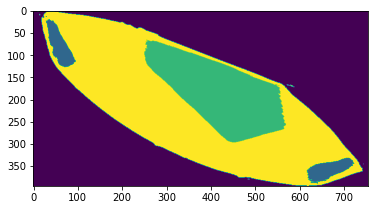

In [77]:
plt.imshow(segmentation[430])

In [65]:
from PIL import Image

In [75]:
num = 430
im = np.array(Image.open("/dls/science/users/lqg38422/DATA/13284/gt/segment_132840430.tif"))

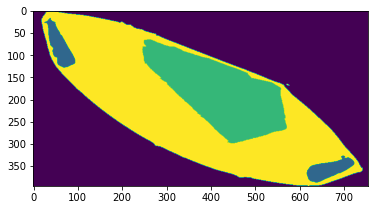

In [76]:
plt.imshow(im)